In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wntr
from pathlib import Path
from infrarisk.src.network_sim_models.interdependencies import *
from infrarisk.src.network_recovery import *

import math
import copy

In [3]:
network_dir= 'micropolis'

MAIN_DIR = Path('../..')
water_file = MAIN_DIR/'infrarisk/data/networks/{0}/water/water.inp'.format(network_dir)

step_size = 60
try:
    wn_original = wntr.network.WaterNetworkModel(water_file)
    wn_original.options.time.duration = 3600
    wn_original.options.time.report_timestep = 3600
    wn_original.options.time.hydraulic_timestep = 60
    wn_original.options.hydraulic.demand_model = 'PDA' #'DDA'
    
    print("Water network successfully loaded.")
except FileNotFoundError:
    print("Error: The water network file does not exist. No such file or directory: ", water_file)

Water network successfully loaded.


C:\Users\srijith\anaconda3\envs\redcar\lib\site-packages\wntr\epanet\io.py:2173: UserWarning: Not all curves were used in "..\..\infrarisk\data\networks\micropolis\water\water.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


In [3]:
import infrarisk.src.network_sim_models.water.water_network_model as water

In [4]:
water_dir = MAIN_DIR/'infrarisk/data/networks/{0}/water'.format(network_dir)
#water.generate_base_supply(wn, dir = water_dir)

# Add all controls in one go

In [5]:
wn = copy.deepcopy(wn_original)
wn.options.hydraulic.required_pressure = 30
wn.options.hydraulic.minimum_pressure = 0
wn.options.hydraulic.threshold_pressure = 20

In [11]:
#components = ['W_PSC282', 'W_PMA535', 'W_PSC1054', 'W_PMA1043']
pipes = {'W_PMA512': [6000, 75000, 85800], 
        'W_PMA828': [6000, 6780, 24780], 
        'W_PMA825': [6000, 25380, 43380], 
        'W_PMA692': [6000, 63540, 74340], 
        'W_PMA799': [6000, 44460, 62940],
        }

pumps = {'W_WP1': [6000, 7080, 25080], 
        'W_WP2': [6000, 7080, 25080], 
        'W_WP3': [6000, 7080, 25080], 
        'W_WP4': [6000, 7080, 25080], 
        'W_WP5': [6000, 7080, 25080], 
        'W_WP6': [6000, 7080, 25080], 
        'W_WP7': [6000, 7080, 25080], 
        'W_WP8': [6000, 7080, 25080]
}

# for pipe_name in pipes.keys():
#     wn = wntr.morph.split_pipe(wn, pipe_name, f"{pipe_name}_B", f"{pipe_name}_leak_node")

#     leak_node = wn.get_node(f"{pipe_name}_leak_node")
#     leak_node.remove_leak(wn)
#     leak_node.add_leak(wn,area=0.75*(math.pi*(wn.get_link(f"{pipe_name}_B").diameter)** 2)/4,
#         start_time=pipes[pipe_name][0],
#         end_time=pipes[pipe_name][1],
#     )

#     link_close_event(wn, f"{pipe_name}_B", pipes[pipe_name][1], "repairing")
#     link_open_event(wn, f"{pipe_name}_B", pipes[pipe_name][2], "repairing")

for pump_name in pumps.keys():
    pump = wn.get_link(pump_name)
    pump.add_outage(
        wn,
        pumps[pump_name][0],
        pumps[pump_name][2],
    )

In [12]:
base_supply_df = pd.DataFrame(columns=["time", "base_supply"])
water_node_head_df = None

while wn.options.time.duration <=  10*3600:
    print("Simulation time: ", wn.options.time.duration,"; Hydraulic time step: ", wn.options.time.hydraulic_timestep, "; Report time step: ", wn.options.time.report_timestep)
    wn_sim = wntr.sim.WNTRSimulator(wn)
    wn_results = wn_sim.run_sim(convergence_error=True, solver_options={"MAXITER": 10000})

    if water_node_head_df is None:
        water_node_head_df = wn_results.node['demand']
        water_node_head_df['time'] = wn_results.node['demand'].index
    else:
        water_node_head_df_new =  wn_results.node["demand"]
        water_node_head_df_new['time'] = wn_results.node['demand'].index
        water_node_head_df = pd.concat(
            [water_node_head_df, water_node_head_df_new],
            ignore_index=True,
        )
            
    #print('failed pipe flowrate: ', wn_results.link['flowrate'][components].values)
    #print('total leak demand: ', wn_results.node['leak_demand'][[f'{component}_leak_node' for component in pipes]].round(decimals=4).values)
    print('tank head: ', wn_results.node['head']['W_T1'].round(decimals=4).values)
    print('total pump flow rate: ', wn_results.link['flowrate'][wn.pump_name_list].round(decimals=4).values)
    print('Pump status: ', wn_results.link['status'][wn.pump_name_list].round(decimals=4).values)
    
    sim_time = wn.options.time.duration
    
    base_demands_at_t = []
    node_demand = wn_results.node["demand"].iloc[-1]
    node_pressure = wn_results.node["pressure"].iloc[-1]

    water_supplied_at_t = []
    
    for junc in wn.junction_name_list:
        if (
            node_pressure[junc]
            > wn.options.hydraulic.threshold_pressure
        ):
            water_supplied_at_t.append(node_demand[junc])
        elif (
            node_pressure[junc]
            < wn.options.hydraulic.threshold_pressure) and (node_pressure[junc] >= 0
        ):
            water_supplied_at_t.append(
                node_demand[junc]
                * math.sqrt(
                    node_pressure[junc]
                    / wn.options.hydraulic.threshold_pressure
                )
            )
    base_supply_df = base_supply_df.append({"time": int(wn.options.time.duration), 
                                            "base_supply": sum(water_supplied_at_t)}, 
                                            ignore_index=True)    
    for junc in wn.junction_name_list:
        base_demand = wn.get_node(junc).base_demand

        if base_demand != 0:
            pattern = (
                wn.get_node(junc)
                .demand_timeseries_list[0]
                .pattern.multipliers
            )
            pattern_size = len(pattern)
            pattern_interval = 24 / pattern_size
            pattern_index = math.floor(
                (((sim_time) / 3600) % 24) / pattern_interval
            )

            multiplier = pattern[pattern_index]
            base_demands_at_t.append(multiplier * base_demand)

    print("Time: ",wn.options.time.duration, "Supply: ", sum(water_supplied_at_t), "Base demand: ", sum(base_demands_at_t))
    
    print('***************')
    wn.options.time.duration += 3600
    wn.options.time.report_timestep += 3600
    


Simulation time:  3600.0 ; Hydraulic time step:  60.0 ; Report time step:  3600
tank head:  [352.044 352.681]
total pump flow rate:  [[0.001 0.001 0.001 0.001 0.069 0.    0.    0.064]
 [0.001 0.001 0.001 0.001 0.068 0.    0.    0.064]]
Pump status:  [[1 1 1 1 1 0 0 1]
 [1 1 1 1 1 0 0 1]]
Time:  3600.0 Supply:  0.03606376158122986 Base demand:  0.0360637615782266
***************
Simulation time:  7200.0 ; Hydraulic time step:  60.0 ; Report time step:  7200
tank head:  [352.864]
total pump flow rate:  [[0. 0. 0. 0. 0. 0. 0. 0.]]
Pump status:  [[0 0 0 0 0 0 0 0]]
Time:  7200.0 Supply:  0.037553965758405694 Base demand:  0.03755396575620661
***************
Simulation time:  10800.0 ; Hydraulic time step:  60.0 ; Report time step:  10800
tank head:  [352.123]
total pump flow rate:  [[0. 0. 0. 0. 0. 0. 0. 0.]]
Pump status:  [[0 0 0 0 0 0 0 0]]
Time:  10800.0 Supply:  0.04200913609813331 Base demand:  0.04200915624216557
***************
Simulation time:  14400.0 ; Hydraulic time step:  60.0 

In [18]:
water_node_head_df

,W_JIN0,W_JTN1,W_JIN2,W_JTN3,W_JIN4,W_JTN5,W_JIN6,W_JTN7,W_JIN8,W_JTN9,...,W_JTN1829,W_JTN1830,W_JTN1831,W_JTN1832,W_JTN1833,W_JTN1834,W_T1,W_R1,W_R2,time
0,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,0.032432,-0.004786,-0.063710,0
1,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,0.032072,-0.004426,-0.063710,3600
2,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,0.030285,-0.004130,-0.063709,7200


# Add controls iteratively

In [46]:
network_dir= 'micropolis'

MAIN_DIR = Path('../..')
water_file = MAIN_DIR/'infrarisk/data/networks/{0}/water/water.inp'.format(network_dir)

step_size = 60
try:
    wn_original = wntr.network.WaterNetworkModel(water_file)
    wn_original.options.time.duration = 60
    wn_original.options.time.report_timestep = 60
    wn_original.options.time.hydraulic_timestep = 60
    wn_original.options.hydraulic.demand_model = 'DDA'
    
    print("Water network successfully loaded.")
except FileNotFoundError:
    print("Error: The water network file does not exist. No such file or directory: ", water_file)
    
wn = copy.deepcopy(wn_original)
wn.options.hydraulic.required_pressure = 30
wn.options.hydraulic.minimum_pressure = 0
wn.options.hydraulic.threshold_pressure = 20

unique_time_stamps = [0, 60, 6060, 6840, 7140, 18780, 24720, 24840, 24960, 25020, 25080, 
 25140, 25260, 25380, 25440, 25860, 37500, 43320, 43440, 43560, 43680, 
 43740, 43860, 43980, 44100, 44520, 45000, 56220, 62400, 62520, 62640, 
 62760, 62880, 63000, 63120, 63240, 63600, 74280, 74400, 74520, 74640, 
 74940, 75060, 85740, 85860, 85980, 86100, 93420, 93540, 93660, 93780]

unique_time_differences = [
            x - unique_time_stamps[i - 1] for i, x in enumerate(unique_time_stamps)
        ][1:]

pipes = {'W_PMA512': [6000, 75000, 85800], 
        'W_PMA828': [6000, 6780, 24780], 
        'W_PMA825': [6000, 25380, 43380], 
        'W_PMA692': [6000, 63540, 74340], 
        'W_PMA799': [6000, 44460, 62940],
        }

pumps = {'W_WP1': [6000, 7080, 25080], 
        'W_WP2': [6000, 7080, 25080], 
        'W_WP3': [6000, 7080, 25080], 
        'W_WP4': [6000, 7080, 25080], 
        'W_WP5': [6000, 7080, 25080], 
        'W_WP6': [6000, 7080, 25080], 
        'W_WP7': [6000, 7080, 25080], 
        'W_WP8': [6000, 7080, 25080]
}

for pipe_name in pipes.keys():
    wn = wntr.morph.split_pipe(wn, pipe_name, f"{pipe_name}_B", f"{pipe_name}_leak_node")

    
base_supply_df = pd.DataFrame(columns=["time", "base_supply"])

base_water_ctrls = ['1', '2', '3', '4', '5', '6', '7']

for index, time_stamp in enumerate(unique_time_stamps[1:18]):
    print("Simulation time: ", wn.options.time.duration,"; Hydraulic time step: ", wn.options.time.hydraulic_timestep, "; Report time step: ", wn.options.time.report_timestep)
    
    
        
    #print(wn.control_name_list)
    wn_sim = wntr.sim.WNTRSimulator(wn)
    wn_results = wn_sim.run_sim(convergence_error=True, solver_options={"MAXITER": 10000})
    
    remove_ctrl_list = list(set(wn.control_name_list) - set(base_water_ctrls))
    
    for ctrl in remove_ctrl_list:
        wn.remove_control(ctrl)
        
    for pipe_name in pipes.keys():
        if pipes[pipe_name][0] <= time_stamp < pipes[pipe_name][1]:
            leak_node = wn.get_node(f"{pipe_name}_leak_node")
            leak_node.remove_leak(wn)
            leak_node.add_leak(wn,area=0.75*(math.pi*(wn.get_link(f"{pipe_name}_B").diameter)** 2)/4,
                start_time=time_stamp,
                end_time=unique_time_stamps[index + 1],
            )
        elif pipes[pipe_name][1] <= time_stamp < pipes[pipe_name][2]:
            link_close_event(wn, f"{pipe_name}_B", time_stamp, "repairing")
            link_open_event(wn, f"{pipe_name}_B", unique_time_stamps[index + 1], "repairing") 
    
    for pump_name in pumps.keys():
        if pumps[pump_name][0] <= time_stamp < pumps[pump_name][2]:
            pump = wn.get_link(pump_name)
            pump.add_outage(
                wn,
                time_stamp,
                unique_time_stamps[index + 1],
            )
    
    #print('failed pipe flowrate: ', wn_results.link['flowrate'][components].values)
    print('total leak demand: ', wn_results.node['leak_demand'][[f'{component}_leak_node' for component in pipes]].round(decimals=4).values)
    #print('tank head: ', wn_results.node['head']['W_T1'].round(decimals=4).values)
    #print('total pump flow rate: ', wn_results.link['flowrate'][wn.pump_name_list].round(decimals=4).values)
    print('Pump status: ', wn_results.link['status'][wn.pump_name_list].round(decimals=4).values)
    
    sim_time = wn.options.time.duration
    
    base_demands_at_t = []
    node_demand = wn_results.node["demand"].iloc[-1]
    node_pressure = wn_results.node["pressure"].iloc[-1]

    water_supplied_at_t = []
    
    for junc in wn.junction_name_list:
        if (
            node_pressure[junc]
            > wn.options.hydraulic.threshold_pressure
        ):
            water_supplied_at_t.append(node_demand[junc])
        elif (
            node_pressure[junc]
            < wn.options.hydraulic.threshold_pressure) and (node_pressure[junc] >= 0
        ):
            water_supplied_at_t.append(
                node_demand[junc]
                * math.sqrt(
                    node_pressure[junc]
                    / wn.options.hydraulic.threshold_pressure
                )
            )        
    
    base_supply_df = base_supply_df.append({"time": int(wn.options.time.duration), 
                                            "base_supply": sum(water_supplied_at_t)}, 
                                            ignore_index=True)    
    for junc in wn.junction_name_list:
        base_demand = wn.get_node(junc).base_demand

        if base_demand != 0:
            pattern = (
                wn.get_node(junc)
                .demand_timeseries_list[0]
                .pattern.multipliers
            )
            pattern_size = len(pattern)
            pattern_interval = 24 / pattern_size
            pattern_index = math.floor(
                (((sim_time) / 3600) % 24) / pattern_interval
            )

            multiplier = pattern[pattern_index]
            base_demands_at_t.append(multiplier * base_demand)

    print("Time: ",wn.options.time.duration, "Supply: ", sum(water_supplied_at_t), "Base demand: ", sum(base_demands_at_t))
    
    print('***************')
    wn.options.time.duration += unique_time_differences[index+1]
    wn.options.time.report_timestep += unique_time_differences[index+1]
    


Water network successfully loaded.
Simulation time:  60.0 ; Hydraulic time step:  60.0 ; Report time step:  60
total leak demand:  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Pump status:  [[1 1 1 1 1 0 0 1]
 [1 1 1 1 1 0 0 1]]
Time:  60.0 Supply:  0.0360637615782266 Base demand:  0.0360637615782266
***************
Simulation time:  6060.0 ; Hydraulic time step:  60.0 ; Report time step:  6060
total leak demand:  [[0. 0. 0. 0. 0.]]
Pump status:  [[1 1 1 1 1 0 0 1]]
Time:  6060.0 Supply:  0.0360637615782266 Base demand:  0.0360637615782266
***************
Simulation time:  6840.0 ; Hydraulic time step:  60.0 ; Report time step:  6840
total leak demand:  [[0. 0. 0. 0. 0.]]
Pump status:  [[1 1 1 1 1 0 0 1]]
Time:  6840.0 Supply:  0.0360637615782266 Base demand:  0.0360637615782266
***************
Simulation time:  7140.0 ; Hydraulic time step:  60.0 ; Report time step:  7140
total leak demand:  [[0. 0. 0. 0. 0.]]
Pump status:  [[1 1 1 1 1 0 0 1]]
Time:  7140.0 Supply:  0.0360637615782266 Base de

In [12]:
list(set(['a', 'b', 'c']) - set(['a', 'b']))

['c']

# Plot results

In [6]:
folder = 'C:/Users/srijith/Dropbox/Intra-CREATE Seed Grant/Integrated Model/dreaminsg_integrated_model/infrarisk/data/networks/micropolis/scenarios/'

In [187]:
strategies = ['capacity', 'centrality', 'crewdist', 'zone']

auc_df = pd.DataFrame(columns = ["scenario", "capacity", "centrality", "crewdist", "zone", "fail_count"])
abnormal_results = []

scenarios = [f for f in sorted(os.listdir(folder))]
for scenario in scenarios:
     
    auc_dict = {"scenario": scenario, "capacity": None, "centrality": None, "crewdist": None, "zone": None, "fail_count": None}
    
    disruption_file = pd.read_csv(f"{folder}/{scenario}/disruption_file.csv")
    auc_dict["fail_count"] = disruption_file.shape[0]
    for strategy in strategies:
        fname = f"{folder}/{scenario}/{strategy}/network_performance.csv"
        if os.path.isfile(fname):
            df = pd.read_csv(fname)
            if (df["water_perf"].iloc[-1] > 0.95) and (auc_dict["fail_count"] > 10):
                time_tracker = df.time_min
                water_consump_tracker = df.water_perf
                power_consump_tracker = df.power_perf
                
                water_auc = metrics.auc(time_tracker, water_consump_tracker)  # / max(self.time_tracker)
                power_auc = metrics.auc(time_tracker,power_consump_tracker)  # / max(self.time_tracker)

                weighed_auc = round(0.5 *water_auc + 0.5 * power_auc,2)
                auc_dict[strategy] = weighed_auc
            else:
                abnormal_results.append(scenario)
    auc_df = auc_df.append(auc_dict, ignore_index=True)
    # print("Capacity: ", auc_dict["capacity"], "; Centrality: ", auc_dict["centrality"],
    #         "; Crew-distance: ", auc_dict["crewdist"], "; Zone: ", auc_dict["zone"])
abnormal_results = list(set(abnormal_results))
auc_df.head(2)

,scenario,capacity,centrality,crewdist,zone,fail_count
0,point15,NaN,NaN,NaN,NaN,2
1,point16,NaN,NaN,NaN,NaN,1


In [188]:
# auc_df_wide = auc_df.reset_index()
auc_df_wide = auc_df.dropna()

In [189]:
auc_df_wide_norm = copy.deepcopy(auc_df_wide)
for strategy in strategies:
    auc_df_wide_norm[strategy] = auc_df_wide[strategy] - auc_df_wide["zone"]
# auc_df_wide_norm.head(2)

In [190]:
auc_df_long = pd.melt(auc_df_wide_norm, id_vars=['scenario', "fail_count"], value_vars=strategies)
auc_df_long.columns = ["scenario", "fail_count", "strategy", "AUC"]

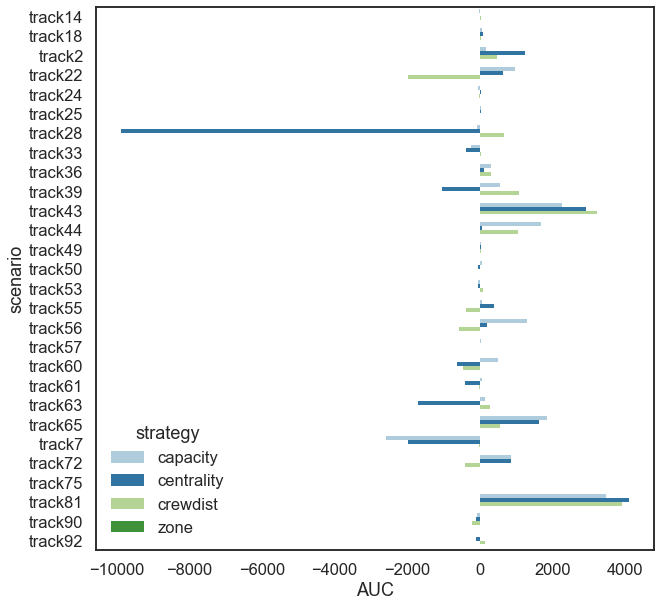

In [192]:
sns.set_context('talk')
sns.set_style("white")
sns.set_context(rc = {'patch.linewidth': 0.0})
fig = plt.figure(figsize = (10,10))
ax = sns.barplot(x= 'AUC', 
                 y = 'scenario', 
                 hue =  'strategy',  
                 data = auc_df_long, 
                 orient='h', 
                 dodge=True, 
                 palette=("Paired"))

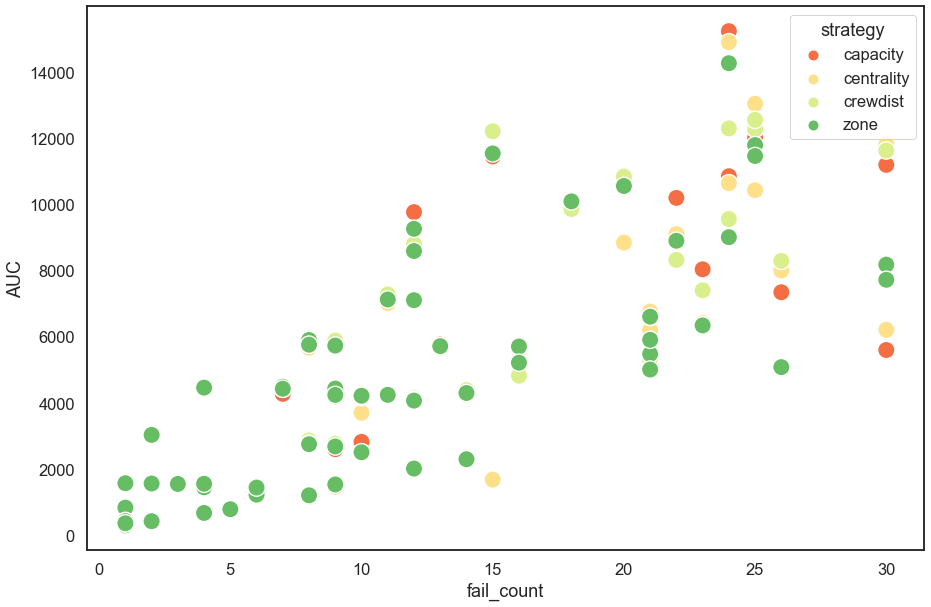

In [8]:
sns.set_context('talk')
sns.set_style("white")
sns.set_context(rc = {'patch.linewidth': 1})
fig = plt.figure(figsize = (15,10))
ax = sns.scatterplot(x= 'fail_count', 
                 y = "AUC", 
                 hue =  'strategy',
                 data = auc_d
                 alpha = 0.5f_long,
                 palette=("RdYlGn"),
                 s=300,
                 )

In [156]:
abnormal_results

['track38',
 'track52',
 'track78',
 'track69',
 'track85',
 'track17',
 'track83',
 'track91',
 'track87',
 'track19',
 'track70',
 'track79',
 'track89',
 'track66',
 'track13']

In [11]:
c_f = list(range(1,31))

n_r = pd.DataFrame(columns = ["c_f", "n"])

for index, count in enumerate(c_f):
    

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]